# Landing Performance Assignment

In [66]:
import math
import qty
import numpy as np
import atmosphere
import pandas as pd
import matplotlib.pyplot as plt

## Deliverable 1 - Dispatch Landing Chart

### Conditions:
- Dry AND wet runways
- Mass variation from 170 to 230 tons, steps of 10 tons
- Field elevation sea level, up to and including 5000 ft, steps of 1000 ft
- Zero wind

### Aircraft data
- Wingspan, $b = 64.5 m$
- Wing surface, $S = 436.8 m^2$
- Oswald factor, $e = 0.8$
- Parasitic drag coefficient in landing configuration, $C_{D_0} = 0.088$
- Braking coefficient on dry runway, $\mu_{dry} = 0.54$
- Braking coefficient on wet runway, $\mu_{wet} = 0.34$
- Lift coefficient in ground run, $C_{L_{gnd}} = 0.126$
- Drag coefficient in ground run, $C_{D_{gnd}} = 0.213$
- IAS stall at 200 tons with flaps 30, ${IAS}_{stall} = 122 Kts$
- Speed during approach, $v_{ref} = 1.23 \cdot {IAS}_{stall}$
- Speed at touchdown, $v_{td} = 1.18 \cdot {IAS}_{stall}$
- Time of transition phase, $t_{tr} = 1.3 s$
- Speed decay factor of transition phase of landing run, $decay = 0.85$
- Thrust per engine at touchdown, $T = 3400 lbs$

### Assumptions
- Landing flaps 30
- Drag polar is exactly parabolic

Initialize the variables in python:

In [48]:
mass = qty.Mass.M_ton(200)
wingspan = qty.Distance(64.5)
surface = qty.Area(436.8)
oswald = 0.8
cd0_land = 0.088
mu_dry = 0.54
mu_wet = 0.34
cl_gnd = 0.126
cd_gnd = 0.213
ias_stall = qty.Velocity.Kts(122)
v_stall_to_ref = 1.23
v_stall_to_td = 1.18
transition_time = qty.Time(1.3)
speed_decay = 0.85
thrust_land = qty.Force.Lbf(3400 * 2)


# More assumptions

# Modern aircraft, so flare height = screen height = 50 ft
flare_height = qty.Distance.Ft(50)

# Assume that the flare is decelerating

# Assume ILS approach, 3 degrees fpa
fpa = math.radians(3)

In [49]:
aspect_ratio = wingspan**2 / surface
cdi_k_const = 1 / (math.pi * oswald * aspect_ratio)
cdi_k_const

0.04177566200501165

In [50]:
cl_max = (2 * 9.81 * mass) / (1.225 * ias_stall**2 * surface)
print(cl_max)

1.8617169631927402


In [51]:
def get_tas_stall(mass, elevation):
    density = atmosphere.get_density_at_height(elevation)
    ias_stall = math.sqrt((2 * 9.81 * mass) / (surface * cl_max * density))
    tas_stall = ias_stall * math.sqrt(1.225 / density)
    
    return tas_stall

In [52]:
def average_tmind(mass, elevation, tas_stall):
    weight = mass * 9.81
    t_min_d_b = -(weight * math.sin(fpa))
    density = atmosphere.get_density_at_height(elevation)
    tas_td = tas_stall * v_stall_to_td
    drag_td = qty.Force(0.5 * density * tas_td**2 * surface * cd_gnd)
    t_min_d_c = qty.Force(thrust_land - drag_td)
    t_min_d_avg = qty.Force((t_min_d_b + t_min_d_c) / 2)
    
    return t_min_d_avg

In [53]:
def get_trans_dist(v_td, speed_decay, trans_time):
    brakes_on_speed = qty.Velocity(speed_decay * v_td)
    avg_trans_speed = qty.Velocity((v_td + brakes_on_speed) / 2)
    trans_dist = qty.Distance(trans_time * avg_trans_speed)
    
    return trans_dist

In [54]:
def get_segment_dist(v_from, v_to, thrust, density, mass, mu):
    weight = qty.Force.Kg(mass)
    v_avg = (v_from + v_to) / 2
    
    drag_from = 0.5 * density * v_from**2 * surface * cd_gnd
    drag_to = 0.5 * density * v_to**2 * surface * cd_gnd

    lift_from = 0.5 * density * v_from**2 * surface * cl_gnd
    lift_to = 0.5 * density * v_to**2 * surface * cl_gnd

    accel_from = (9.81 * (thrust - drag_from - mu * (weight - lift_from))) / weight
    accel_to = (9.81 * (thrust - drag_to - mu * (weight - lift_to))) / weight

    accel_avg = (accel_from + accel_to) / 2
    delta_v = v_from - v_to
    delta_dist = v_avg * delta_v / accel_avg

    return -delta_dist
    
    
def get_brake_dist(thrust, v_brakes_on, density, mass, mu):
    distance = 0
    
    resid_speed = int(v_brakes_on)
    
    distance += get_segment_dist(v_brakes_on, int(v_brakes_on), thrust_land, density, mass, mu)
    
    while (resid_speed > 0):
        distance += get_segment_dist(resid_speed, resid_speed - 1, thrust, density, mass, mu)
        resid_speed -= 1
    
    return qty.Distance(distance)



In [65]:
masses = [qty.Mass.M_ton(m) for m in np.arange(170, 240, 10)]
elevations = [qty.Distance.Ft(h) for h in np.arange(0, 6000, 1000)]

df = pd.DataFrame({"mass": [], "elevation": [], "distance": []})

for mass1 in masses:
    for elev in elevations:
        tas_stall = get_tas_stall(mass1, elev)
        t_min_d_avg = average_tmind(mass1, elev, tas_stall)
        
        weight = mass1 * 9.81
        density_flare = atmosphere.get_density_at_height(elev + flare_height)
        density_td = atmosphere.get_density_at_height(elev)
        
        tas_b = tas_stall * v_stall_to_ref
        tas_c = tas_stall * v_stall_to_td
        
        dist_flare = qty.Distance((weight / (2 * 9.81) * (tas_c**2 - tas_b**2) - weight * flare_height) / t_min_d_avg)
        dist_trans = get_trans_dist(tas_c, speed_decay, transition_time)
        dist_brake = get_brake_dist(thrust_land, tas_c * speed_decay, density_td, mass1, mu_dry)

        dist_total = qty.Distance(dist_flare + dist_trans + dist_brake)
        print(f"Mass: {int(mass1.m_ton)} ton, Elev: {int(elev.ft):04} ft, Flare: {dist_flare}, Trans: {dist_trans}, Brake: {dist_brake}, Total: {dist_total}")
        df.loc[len(df)] = {"mass": int(mass1.m_ton), "elevation": int(elev.ft), "distance": float(dist_total.base)}


    print()

df

Mass: 170 ton, Elev: 0000 ft, Flare: 370.04 meters, Trans: 82.09 meters, Brake: 306.39 meters, Total: 758.52 meters
Mass: 170 ton, Elev: 1000 ft, Flare: 373.72 meters, Trans: 84.54 meters, Brake: 324.29 meters, Total: 782.56 meters
Mass: 170 ton, Elev: 2000 ft, Flare: 377.75 meters, Trans: 87.08 meters, Brake: 343.35 meters, Total: 808.18 meters
Mass: 170 ton, Elev: 3000 ft, Flare: 382.12 meters, Trans: 89.71 meters, Brake: 363.66 meters, Total: 835.49 meters
Mass: 170 ton, Elev: 4000 ft, Flare: 386.85 meters, Trans: 92.44 meters, Brake: 385.30 meters, Total: 864.60 meters
Mass: 170 ton, Elev: 5000 ft, Flare: 391.96 meters, Trans: 95.28 meters, Brake: 408.38 meters, Total: 895.61 meters

Mass: 180 ton, Elev: 0000 ft, Flare: 380.55 meters, Trans: 84.47 meters, Brake: 323.83 meters, Total: 788.86 meters
Mass: 180 ton, Elev: 1000 ft, Flare: 384.71 meters, Trans: 86.99 meters, Brake: 342.75 meters, Total: 814.45 meters
Mass: 180 ton, Elev: 2000 ft, Flare: 389.21 meters, Trans: 89.60 meters

,mass,elevation,distance
0,170,0,758.521121
1,170,1000,782.555214
2,170,2000,808.177599
3,170,3000,835.488589
4,170,4000,864.595739
5,170,5000,895.614430
6,180,0,788.858328
7,180,1000,814.448641
8,180,2000,841.711897
9,180,3000,870.754046


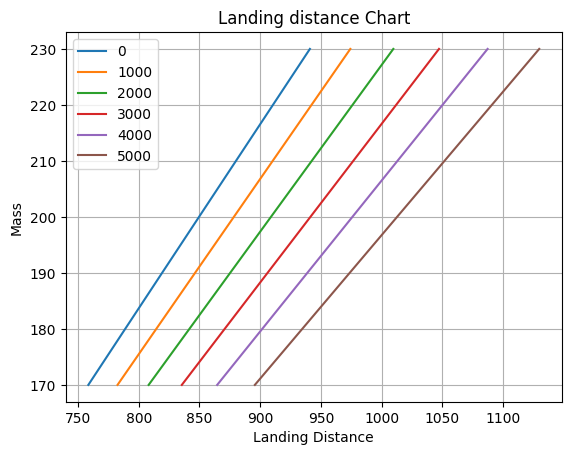

In [96]:
sub = df[df['mass'] == 170]
subsubdf = df[df['mass'] == 180]

for elev in elevations:
    elev = int(elev.ft)
    
    subdf = df[df['elevation'] == elev]

    plt.plot(subdf['distance'], subdf['mass'], label=str(elev))

plt.xlabel('Landing Distance')
plt.ylabel('Mass')
plt.title("Landing distance Chart")
plt.legend()
plt.grid()
plt.show()